In [130]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from numpy.polynomial.polynomial import Polynomial
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import shap
import pkg_resources

In [131]:
# Define parameters
batch_shuffle = True
eval_freq = 1
max_lr = 5e-4
div_factor = 100
pct_start = 0.05
anneal_strategy = 'cos'
final_div_factor = 10000.0
early_stop = False
thres = 5
delta = 0.5
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'

In [132]:
# Load and preprocess the data using the full path
data = pd.read_csv('F:/0 UCAM/project5_SWAT+WETMachineLearning/inputdata_meteo.csv')  # Replace with the actual path to your data file
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Verify the data
print(data.head())

            GOTMWET_O2conc_depth6.5m   U10.m_s   V10.m_s  SurfPressure.hPa  \
Date                                                                         
2003-01-01                  6.922769  2.820000  1.024167       1016.094167   
2003-01-02                  6.899616  2.727917  1.357500       1014.461250   
2003-01-03                  6.788045  3.110833  2.129583       1014.035833   
2003-01-04                  6.877638  1.879167 -0.394167       1012.451667   
2003-01-05                  6.788111  2.123750  2.040000       1006.651667   

            AirTemp.C  DewpointTemp.C  CloudCover_fraction  ShortWave.W_m2  \
Date                                                                         
2003-01-01  13.369583       10.019167             0.944583       82.735000   
2003-01-02  15.137500       11.899167             0.988750      103.125000   
2003-01-03  15.261667       12.022500             0.873333      112.792083   
2003-01-04  15.087083       10.619167             0.283750     

In [133]:
# Prepare the input and output columns
X_columns = ['U10.m_s', 'V10.m_s', 'SurfPressure.hPa', 'AirTemp.C', 'DewpointTemp.C', 'CloudCover_fraction', 'ShortWave.W_m2', 'Precip.m_day']
y_column = 'GOTMWET_O2conc_depth6.5m'

In [134]:
# Scale the features using all available data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(data[X_columns].values)
y_scaled = scaler_y.fit_transform(data[y_column].values.reshape(-1, 1)).flatten()

In [135]:
# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2941, shuffle=False) # 0.2941 is approximately 25% of 0.85

In [136]:
# Define the time step
time_step = 7  # Number of time steps

In [137]:
# Helper function to create sequences
def create_sequences(X, y, time_step):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:(i + time_step), :])
        y_seq.append(y[i + time_step])
    return np.array(X_seq), np.array(y_seq)

In [138]:
# Create sequences for training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2941, shuffle=False)  # 0.2941 is approximately 25% of 0.85

X_train_val_seq, y_train_val_seq = create_sequences(X_train_val, y_train_val, time_step)
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_step)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_step)

print(f"X_train_val_seq shape: {X_train_val_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

# Check for NaN values
print(f"Number of NaNs in X_train_val_seq: {np.isnan(X_train_val_seq).sum()}")
print(f"Number of NaNs in y_train_seq: {np.isnan(y_train_seq).sum()}")
print(f"Number of NaNs in y_val_seq: {np.isnan(y_val_seq).sum()}")

# Check the combined length of y_train_seq and y_val_seq
combined_length = len(y_train_seq) + len(y_val_seq)
print(f"Combined length of y_train_seq and y_val_seq: {combined_length}")
print(f"Length of X_train_val_seq: {len(X_train_val_seq)}")

X_train_val_seq shape: (6512, 7, 8)
y_train_seq shape: (4594,)
y_val_seq shape: (1911,)
Number of NaNs in X_train_val_seq: 0
Number of NaNs in y_train_seq: 0
Number of NaNs in y_val_seq: 0
Combined length of y_train_seq and y_val_seq: 6505
Length of X_train_val_seq: 6512


In [139]:
# Adjust lengths to match
min_length = min(len(X_train_val_seq), combined_length)
X_train_val_seq = X_train_val_seq[:min_length]
y_train_val_seq = np.concatenate((y_train_seq, y_val_seq))[:min_length]

print(f"Adjusted X_train_val_seq shape: {X_train_val_seq.shape}")
print(f"Adjusted y_train_val_seq shape: {y_train_val_seq.shape}")

Adjusted X_train_val_seq shape: (6505, 7, 8)
Adjusted y_train_val_seq shape: (6505,)


In [140]:
# Define the K-Fold cross-validator
k = 5  # Number of folds
kf = KFold(n_splits=k)

# Initialize variables to store metrics for each fold
fold_metrics = []

In [163]:
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_seq)):
    print(f"Training on fold {fold+1}...")
    X_train_fold, X_val_fold = X_train_seq[train_index], X_train_seq[val_index]
    y_train_fold, y_val_fold = y_train_seq[train_index], y_train_seq[val_index]

    # Build the LSTM model with dropout
    model = Sequential()
    model.add(LSTM(8, return_sequences=True, input_shape=(time_step, X_train_fold.shape[2])))
    model.add(Dropout(0.2))  # Add dropout layer with 0.2 dropout rate
    model.add(LSTM(8))  # Second LSTM layer
    model.add(Dropout(0.2))  # Add another dropout layer
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=16, verbose=0, shuffle=batch_shuffle)

    # Predict using the trained model
    y_pred_train_fold = model.predict(X_train_fold).flatten()
    y_pred_val_fold = model.predict(X_val_fold).flatten()

    # Inverse transform to get original scale
    y_train_fold = scaler_y.inverse_transform(y_train_fold.reshape(-1, 1)).flatten()
    y_val_fold = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1)).flatten()
    y_pred_train_fold = scaler_y.inverse_transform(y_pred_train_fold.reshape(-1, 1)).flatten()
    y_pred_val_fold = scaler_y.inverse_transform(y_pred_val_fold.reshape(-1, 1)).flatten()

    # Calculate metrics for the train period of the current fold
    train_metrics = {
        'NSE': 1 - (sum((y_train_fold - y_pred_train_fold)**2) / sum((y_train_fold - y_train_fold.mean())**2)),
        'RMSE': np.sqrt(mean_squared_error(y_train_fold, y_pred_train_fold)),
        'MAE': np.mean(np.abs(y_train_fold - y_pred_train_fold)),
        'PBIAS': 100 * sum(y_train_fold - y_pred_train_fold) / sum(y_train_fold)
        }

    # Calculate metrics for the validation period of the current fold
    val_metrics = {
        'NSE': 1 - (sum((y_val_fold - y_pred_val_fold)**2) / sum((y_val_fold - y_val_fold.mean())**2)),
        'RMSE': np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)),
        'MAE': np.mean(np.abs(y_val_fold - y_pred_val_fold)),
        'PBIAS': 100 * sum(y_pred_val_fold - y_val_fold) / sum(y_val_fold)
        }

    # Append validation metrics to the fold metrics list
    fold_metrics.append({
        'Fold': fold+1,
        'Train_NSE': train_metrics['NSE'],
        'Train_RMSE': train_metrics['RMSE'],
        'Train_MAE': train_metrics['MAE'],
        'Train_PBIAS': train_metrics['PBIAS'],
        'Val_NSE': val_metrics['NSE'],
        'Val_RMSE': val_metrics['RMSE'],
        'Val_MAE': val_metrics['MAE'],
        'Val_PBIAS': val_metrics['PBIAS']
        # Add other metrics as needed
        })

Training on fold 1...


C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training on fold 2...


C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training on fold 3...


C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training on fold 4...


C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training on fold 5...


C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [165]:
# Convert the list of metrics to a DataFrame
fold_metrics_df = pd.DataFrame(fold_metrics)
print(fold_metrics_df)

    Fold  Train_NSE  Train_RMSE  Train_MAE  Train_PBIAS   Val_NSE  Val_RMSE  \
0      1   0.884549    0.493540   0.361899     0.267583  0.711673  0.748074   
1      2   0.866201    0.528724   0.383670     0.457004  0.784376  0.661652   
2      3   0.907227    0.404770   0.306508     0.001629  0.632810  1.074465   
3      4   0.871272    0.535722   0.384138     0.012139  0.766638  0.581481   
4      5   0.867726    0.537842   0.390057     0.054960  0.773096  0.601813   
5      1   0.907670    0.441363   0.329974     0.112264  0.689782  0.775952   
6      2   0.891249    0.476672   0.358053     0.297258  0.752649  0.708661   
7      3   0.915391    0.386550   0.294551    -0.291990  0.643911  1.058099   
8      4   0.900653    0.470630   0.350162    -0.246491  0.757256  0.593056   
9      5   0.895287    0.478539   0.360228     0.332368  0.752759  0.628204   
10     1   0.914380    0.425020   0.319006     0.874262  0.633573  0.843325   
11     2   0.893581    0.471532   0.354919     0.171

In [166]:
# Save the fold metrics to a CSV file
fold_metrics_df.to_csv('F:/0 UCAM/project5_SWAT+WETMachineLearning/5-fold_4-unit_metrics_60_25_15_lstm_O2depth6.5GOTMWET.csv', index=False)

In [167]:
# Train the final model on the entire training and validation set
final_model = Sequential()
final_model.add(LSTM(8, return_sequences=True, input_shape=(time_step, X_train_val_seq.shape[2])))
final_model.add(Dropout(0.2))  # Add dropout layer with 0.2 dropout rate
final_model.add(LSTM(8))  # Second LSTM layer
final_model.add(Dropout(0.2))  # Add another dropout layer
final_model.add(Dense(1))
final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.fit(X_train_val_seq, y_train_val_seq, epochs=100, batch_size=16, verbose=0, shuffle=batch_shuffle)

C:\Users\Sara\.conda\envs\tensorflow_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [168]:
# Predict using the final trained model
y_pred_test = final_model.predict(X_test_seq).flatten()

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [169]:
# Inverse transform to get original scale
y_test = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

In [170]:
# Calculate metrics for the test set
test_metrics = {
    'NSE': 1 - (sum((y_test - y_pred_test)**2) / sum((y_test - y_test.mean())**2)),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'MAE': np.mean(np.abs(y_test - y_pred_test)),
    'PBIAS': 100 * sum(y_pred_test - y_test) / sum(y_test)
    }

In [171]:
# Print and save the test metrics
print('Test Metrics:', test_metrics)

# Convert the test metrics to a DataFrame
test_metrics_df = pd.DataFrame([test_metrics], index=['Test'])

Test Metrics: {'NSE': np.float64(0.5851713734360768), 'RMSE': np.float64(0.7204833777545331), 'MAE': np.float64(0.5184142737441563), 'PBIAS': np.float64(-2.451448648490289)}


In [172]:
# Save the test metrics to a CSV file
test_metrics_df.to_csv('F:/0 UCAM/project5_SWAT+WETMachineLearning/5-fold_4-unit_test_metrics_60_25_15_lstm_O2depth6.5GOTMWET.csv', index=True)

In [173]:
# Predict using the final trained model for the entire dataset
X_scaled_seq, _ = create_sequences(X_scaled, y_scaled, time_step)

In [174]:
# Ensure the reshape dimensions match the total number of elements
if X_scaled_seq.size == 7670 * 7 * 8:
    X_scaled_reshaped = X_scaled_seq.reshape((7670, 7, 8))
else:
    print("Mismatch in the number of elements. Adjust the reshape dimensions.") 

Mismatch in the number of elements. Adjust the reshape dimensions.


In [175]:
# Predict using the final trained model for the entire dataset
y_pred_full = final_model.predict(X_scaled_seq).flatten()

240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [176]:
# Inverse transform to get original scale for the full dataset predictions
y_pred_full_original_scale = scaler_y.inverse_transform(y_pred_full.reshape(-1, 1)).flatten()

In [177]:
# Create a DataFrame with the date index, observed and predicted values
results_df = pd.DataFrame({
'Date': data.index[time_step:],  # Adjust the index to match the sequence length
'ObservedQ': scaler_y.inverse_transform(y_scaled[time_step:].reshape(-1, 1)).flatten(),
'PredictedQ': y_pred_full_original_scale
}).set_index('Date')

In [178]:
# Save the results to an Excel file
results_df.to_csv('F:/0 UCAM/project5_SWAT+WETMachineLearning/20241125_predicted_values_full_time_period_O2depth6.5GOTMWET.csv', index=True)

In [179]:
# Determine the indices for the boundaries
train_end_idx = len(X_train) + time_step
val_end_idx = len(X_train_val) + time_step 

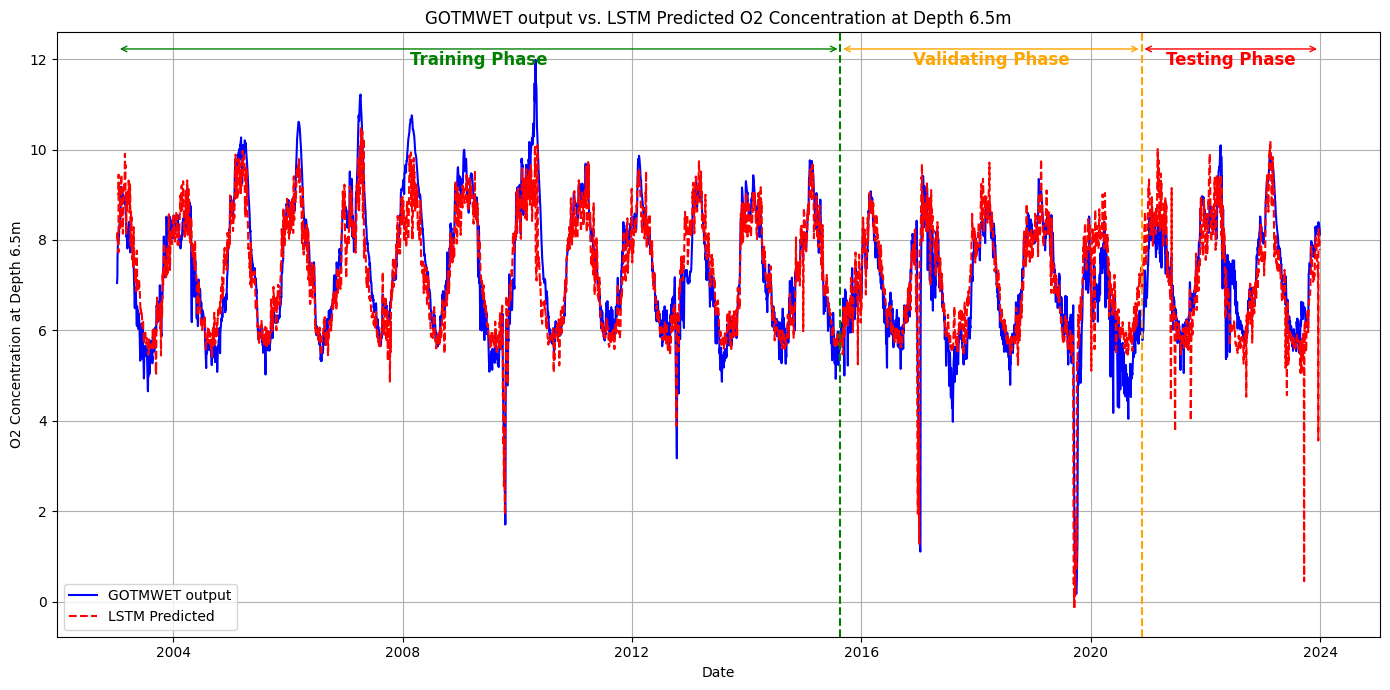

In [180]:
# Plot the observed and predicted values over time with boundaries
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['ObservedQ'], label='GOTMWET output', color='blue')
plt.plot(results_df.index, results_df['PredictedQ'], label='LSTM Predicted', color='red', linestyle='--')

# Add vertical lines to indicate the boundaries
plt.axvline(x=results_df.index[train_end_idx], color='green', linestyle='--')
plt.axvline(x=results_df.index[val_end_idx], color='orange', linestyle='--')

# Add horizontal lines with arrowheads for the periods
plt.annotate('', xy=(results_df.index[train_end_idx], results_df['ObservedQ'].max() * 1.02), 
xytext=(results_df.index[0], results_df['ObservedQ'].max() * 1.02),
arrowprops=dict(arrowstyle='<->', color='green'))
plt.annotate('', xy=(results_df.index[val_end_idx], results_df['ObservedQ'].max() * 1.02), 
xytext=(results_df.index[train_end_idx], results_df['ObservedQ'].max() * 1.02),
arrowprops=dict(arrowstyle='<->', color='orange'))
plt.annotate('', xy=(results_df.index[-1], results_df['ObservedQ'].max() * 1.02), 
xytext=(results_df.index[val_end_idx], results_df['ObservedQ'].max() * 1.02),
arrowprops=dict(arrowstyle='<->', color='red'))

# Add text labels for the periods
plt.text(x=results_df.index[train_end_idx // 2], y=results_df['ObservedQ'].max() * 0.99, s='Training Phase', color='green', ha='center', fontsize=12, fontweight='bold')
plt.text(x=results_df.index[train_end_idx + (val_end_idx - train_end_idx) // 2], y=results_df['ObservedQ'].max() * 0.99, s='Validating Phase', color='orange', ha='center', fontsize=12, fontweight='bold')
plt.text(x=results_df.index[val_end_idx + (len(results_df.index) - val_end_idx) // 2], y=results_df['ObservedQ'].max() * 0.99, s='Testing Phase', color='red', ha='center', fontsize=12, fontweight='bold')

plt.xlabel('Date')
plt.ylabel('O2 Concentration at Depth 6.5m')
plt.title('GOTMWET output vs. LSTM Predicted O2 Concentration at Depth 6.5m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('F:/0 UCAM/project5_SWAT+WETMachineLearning/20241122_Observed_vs_Predicted_O2depth6.5GOTMWET_with_boundaries.png', dpi=300)  # Save the plot in high quality
plt.show()